In [1]:
import numpy as np   
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd    
import matplotlib.pyplot as plt 
from scipy.stats import zscore
import seaborn as sns

In [2]:
powerPlant = pd.read_csv("Folds5x2_pp.csv", header=0 , names = ['Temp','Vacuum','Pressure','Humidity','Power'])

In [3]:
powerPlant.head()

,Temp,Vacuum,Pressure,Humidity,Power
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


In [4]:
powerPlant.describe().T

,count,mean,std,min,25%,50%,75%,max
Temp,9568.0,19.651231,7.452473,1.81,13.5100,20.345,25.72,37.11
Vacuum,9568.0,54.305804,12.707893,25.36,41.7400,52.080,66.54,81.56
Pressure,9568.0,1013.259078,5.938784,992.89,1009.1000,1012.940,1017.26,1033.30
Humidity,9568.0,73.308978,14.600269,25.56,63.3275,74.975,84.83,100.16
Power,9568.0,454.365009,17.066995,420.26,439.7500,451.550,468.43,495.76


Text(0.5,0,'Tempepature - Celsius')

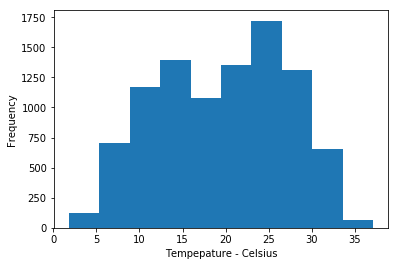

In [44]:
ax = powerPlant['Temp'].plot.hist()
ax.set_xlabel('Tempepature - Celsius')

Text(0.5,0,'Vacuum - Hg')

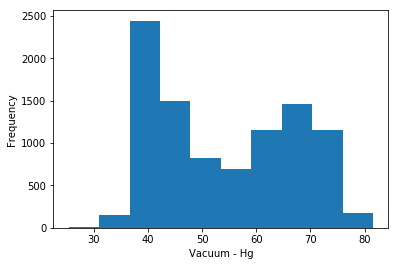

In [45]:
ax = powerPlant['Vacuum'].plot.hist()
ax.set_xlabel('Vacuum - Hg')

Text(0.5,0,'Pressure - Milibar')

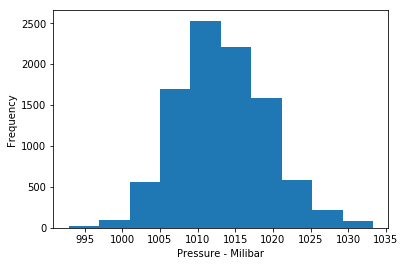

In [46]:
ax = powerPlant['Pressure'].plot.hist()
ax.set_xlabel('Pressure - Milibar')

Text(0.5,0,'Humidity - %')

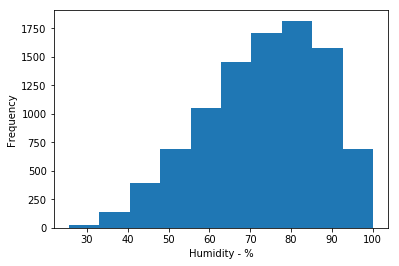

In [47]:
ax = powerPlant['Humidity'].plot.hist()
ax.set_xlabel('Humidity - %')

Text(0.5,0,'Power - MW')

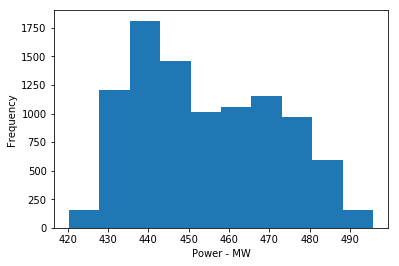

In [48]:
ax = powerPlant['Power'].plot.hist()
ax.set_xlabel('Power - MW')

# Data Analysis

Correlation Graph

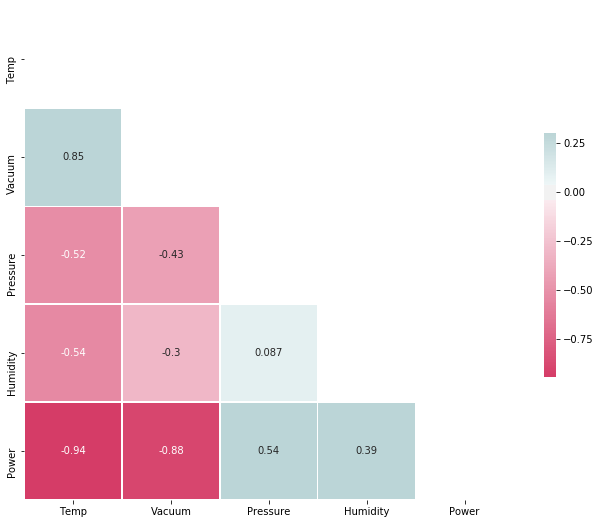

In [5]:
corr = powerPlant.corr(method='spearman') # pearson kendall spearman

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(1,200, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot  = True)

1. Power has a strong negative correlation with 'Ambient Temperature' and 'Exhaust Vacuum' of the Plant. So, it seems that as Temperature or Vacuum increases the Power output of the Plant decreases.
2. Similarly, Power has a positive correlation with Pressure and Humidity. It seems that on increasing Humidity and Pressure, the Power output will increase.
3. Vacuum has a strong positive correlation with Temperature of the plant and also Humidity has a small positive correlation with Pressure.
4. All the other non Power linkages have a negative correlation.

# Training - testing

In [13]:
x = powerPlant[['Temp', 'Vacuum', 'Pressure', 'Humidity']]
y = powerPlant['Power']

In [14]:
## Returns rmse, mae for training section
def calc_train_error(X_train, y_train, model, scaler=None):
    predictions = model.predict(X_train)
    if scaler is not None:
        y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
        predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
    mse = mean_squared_error(y_train, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_train, predictions)
    return rmse, mae
## Returns rmse, mae for testing section
def calc_validation_error(X_test, y_test, model, scaler=None):
    predictions = model.predict(X_test)
    if scaler is not None:
        y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
        predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    return rmse, mae

## Returns errors of model
def calc_metrics(X_train, y_train, X_test, y_test, model, scaler=None):
    '''fits model and returns the RMSE for in-sample error and out-of-sample error'''
    # 
    train_error = calc_train_error(X_train, y_train, model, scaler)
    validation_error = calc_validation_error(X_test, y_test, model, scaler)
    return train_error, validation_error

In [15]:
# Run kfolds with Polynomial Features
def run_kfold_poly(k, lr_or_rf=True):
    degrees = [1,2,3,4,5,6]
    kf = KFold(n_splits=k, shuffle = True, random_state=2020)
    x_array = np.asarray(x)
    result = []
    for degree in degrees:
        total_train_rmse = []
        total_train_mae = []
        total_val_rmse = []
        total_val_mae = []
        
        # Instantiating Model
        i = 0
        for train_index, val_index in kf.split(x_array,y):
            if lr_or_rf:
                model = LinearRegression()
            else:
                model = RandomForestRegressor(n_estimators=500, max_depth=5)
            poly = PolynomialFeatures(degree = degree, interaction_only= True)
            x_poly = poly.fit_transform(x_array)
            # Split data
            x_train, x_val = x_poly[train_index], x_poly[val_index]
            y_train, y_val = y[train_index], y[val_index]
            if isinstance(model, RandomForestRegressor):
                y_train = y_train.ravel()
                y_val = y_val.ravel()
            model.fit(x_train, y_train)
            # Calculate Error
            train_error, val_error = calc_metrics(x_train, y_train, x_val, y_val, model)

            train_rmse = train_error[0]
            train_mae = train_error[1]
            val_rmse = val_error[0]
            val_mae = val_error[1]

            
            total_train_rmse.append(train_rmse)
            total_val_rmse.append(val_rmse)
            total_train_mae.append(train_mae)
            total_val_mae.append(val_mae)
            i += 1
        if lr_or_rf:
            print("Linear Regression")
        else:
            print("Random Forest Regression")
        print("DEGREE: {}".format(degree))
        print("TRAINING RMSE: {} ------ VAL RMSE {}".format(round(np.mean(total_train_rmse), 4), round(np.mean(total_val_rmse), 4)))
        print("TRAINING MAE: {} ------ VAL MAE {}".format(round(np.mean(total_train_mae), 4), round(np.mean(total_val_mae), 4)))
        print("*"*100)
        

# Run kfolds with Standared or MinMax Scaler
def run_kfold_scale(k, lr_or_rf=True, min_max_or_standar=True):
    kf = KFold(n_splits=k, shuffle = True, random_state=2020)
    x_array = np.asarray(x)

    total_train_rmse = []
    total_train_mae = []
    total_val_rmse = []
    total_val_mae = []

    if min_max_or_standar:
        scaler = MinMaxScaler()
        y_scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()
        y_scaler = StandardScaler()

    x_scale = scaler.fit_transform(x_array)
    y_scale = y_scaler.fit_transform(y.values.reshape(-1,1))
    # Instantiating Model
    for train_index, val_index in kf.split(x_scale,y):
        if lr_or_rf:
            model = LinearRegression()
        else:
            model = RandomForestRegressor(n_estimators=500, max_depth=5)
        # Split data
        x_train, x_val = x_scale[train_index], x_scale[val_index]
        y_train, y_val = y_scale[train_index], y_scale[val_index]
        if isinstance(model, RandomForestRegressor):
            y_train = y_train.ravel()
            y_val = y_val.ravel()
        model.fit(x_train, y_train)
        # Calculate Error

        train_error, val_error = calc_metrics(x_train, y_train, x_val, y_val, model, y_scaler)

        train_rmse = train_error[0]
        train_mae = train_error[1]
        val_rmse = val_error[0]
        val_mae = val_error[1]

        total_train_rmse.append(train_rmse)
        total_val_rmse.append(val_rmse)
        total_train_mae.append(train_mae)
        total_val_mae.append(val_mae)

    if lr_or_rf:
        print("Linear Regression")
    else:
        print("Random Forest Regression")

    if min_max_or_standar:
        print("MinMaxScaler")
    else:
        print("StandardScaler")

    print("TRAINING RMSE: {} ------ VAL RMSE {}".format(round(np.mean(total_train_rmse), 4), round(np.mean(total_val_rmse), 4)))
    print("TRAINING MAE: {} ------ VAL MAE {}".format(round(np.mean(total_train_mae), 4), round(np.mean(total_val_mae), 4)))
    print("*"*100)
        

In [16]:
## Excute
run_kfold_poly(k=10, lr_or_rf=True)
run_kfold_scale(k=10, lr_or_rf=True, min_max_or_standar=False)
run_kfold_scale(k=10, lr_or_rf=True, min_max_or_standar=True)

run_kfold_poly(k=10, lr_or_rf=False)
run_kfold_scale(k=10, lr_or_rf=False, min_max_or_standar=False)
run_kfold_scale(k=10, lr_or_rf=False, min_max_or_standar=True)

Linear Regression
DEGREE: 1
TRAINING RMSE: 4.5569 ------ VAL RMSE 4.5571
TRAINING MAE: 3.6251 ------ VAL MAE 3.6277
****************************************************************************************************
Linear Regression
DEGREE: 2
TRAINING RMSE: 4.3068 ------ VAL RMSE 4.3078
TRAINING MAE: 3.3912 ------ VAL MAE 3.3956
****************************************************************************************************
Linear Regression
DEGREE: 3
TRAINING RMSE: 4.2657 ------ VAL RMSE 4.2677
TRAINING MAE: 3.3318 ------ VAL MAE 3.3374
****************************************************************************************************
Linear Regression
DEGREE: 4
TRAINING RMSE: 4.2629 ------ VAL RMSE 4.265
TRAINING MAE: 3.3286 ------ VAL MAE 3.3344
****************************************************************************************************
Linear Regression
DEGREE: 5
TRAINING RMSE: 4.2629 ------ VAL RMSE 4.265
TRAINING MAE: 3.3286 ------ VAL MAE 3.3344
******************

# Training with 2 important features: TEMP - VACCUM

In [9]:
x = powerPlant[['Temp', 'Vacuum']]

In [10]:
x.head()

,Temp,Vacuum
0,8.34,40.77
1,23.64,58.49
2,29.74,56.90
3,19.07,49.69
4,11.80,40.66


In [11]:
# Investigate the performance of Linear Regression and Random Forest with Polynomial Features
run_kfold_poly(k=10, lr_or_rf=True)
run_kfold_poly(k=10, lr_or_rf=False)

Linear Regression
DEGREE: 1
TRAINING RMSE: 4.954 ------ VAL RMSE 4.9527
TRAINING MAE: 3.9174 ------ VAL MAE 3.9189
****************************************************************************************************
Linear Regression
DEGREE: 2
TRAINING RMSE: 4.666 ------ VAL RMSE 4.6641
TRAINING MAE: 3.6578 ------ VAL MAE 3.66
****************************************************************************************************
Linear Regression
DEGREE: 3
TRAINING RMSE: 4.666 ------ VAL RMSE 4.6641
TRAINING MAE: 3.6578 ------ VAL MAE 3.66
****************************************************************************************************
Linear Regression
DEGREE: 4
TRAINING RMSE: 4.666 ------ VAL RMSE 4.6641
TRAINING MAE: 3.6578 ------ VAL MAE 3.66
****************************************************************************************************
Linear Regression
DEGREE: 5
TRAINING RMSE: 4.666 ------ VAL RMSE 4.6641
TRAINING MAE: 3.6578 ------ VAL MAE 3.66
*****************************